In [582]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_curve, auc
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
import re

%matplotlib inline

In [583]:
import pickle

def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open(name + '.pkl', 'rb') as f:
        return pickle.load(f) 


In [584]:
data = pd.read_csv('train.csv')

In [585]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [586]:
data['Surname'] = [re.findall(r'[a-zA-Z]+',name.lower())[0] for name in data.Name]

In [587]:
data['Ticket_type'] = [''.join(re.findall(r'[a-zA-Z]+',ticket.lower())) for ticket in data.Ticket]  

In [588]:
cabins = []
for cabin in data.Cabin:
    if str(cabin) != 'nan':
        cabins.append(cabin[0:1])
    else:
        cabins.append(None)

data['cabin_type'] = cabins

In [589]:
for col in data.columns:
    print(col,data[col].dtype)

PassengerId int64
Survived int64
Pclass int64
Name object
Sex object
Age float64
SibSp int64
Parch int64
Ticket object
Fare float64
Cabin object
Embarked object
Surname object
Ticket_type object
cabin_type object


In [590]:
info_cols = ['Name','Ticket','PassengerId']
target_col = 'Survived'

In [591]:
cat_cols = []

means = {}
cats = {}

for col in data.columns:
    if col in info_cols or col == target_col:
        continue
        
    if data[col].dtype == 'int64' or data[col].dtype == 'float64':
        means[col] = np.mean(data[col])
        data[col] = data[col].fillna(means[col])
    if data[col].dtype == 'object':
        cnt = Counter(data[col].fillna('N/A')).most_common(10)
        keys,values = zip(*cnt)
        cats[col] = keys
        data[col] = [i if i in keys else 'Other' for i in data[col].fillna('N/A')]
        cat_cols.append(col)

In [592]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Ticket_type,cabin_type
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000000,1,0,A/5 21171,7.2500,N/A,S,Other,a,N/A
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000000,1,0,PC 17599,71.2833,Other,C,Other,pc,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000000,0,0,STON/O2. 3101282,7.9250,N/A,S,Other,stono,N/A
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000000,1,0,113803,53.1000,C123,S,Other,,C
4,5,0,3,"Allen, Mr. William Henry",male,35.000000,0,0,373450,8.0500,N/A,S,Other,,N/A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.000000,0,0,211536,13.0000,N/A,S,Other,,N/A
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.000000,0,0,112053,30.0000,Other,S,Other,,B
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,29.699118,1,2,W./C. 6607,23.4500,N/A,S,Other,wc,N/A
889,890,1,1,"Behr, Mr. Karl Howell",male,26.000000,0,0,111369,30.0000,Other,C,Other,,C


In [593]:
#data = pd.get_dummies(data,columns=cat_cols)

In [594]:
labels = {}

for col in cat_cols:
    le = LabelEncoder()
    le.fit(data[col])
    labs = le.transform(pd.unique(data[col]))
    labels[col] = {}
    for i,value in enumerate(pd.unique(data[col])):
        labels[col][value] = labs[i]
    data[col] = le.transform(data[col])

In [595]:
labels

{'Sex': {'male': 1, 'female': 0},
 'Cabin': {'N/A': 9,
  'Other': 10,
  'C123': 1,
  'G6': 8,
  'C23 C25 C27': 3,
  'F33': 7,
  'E101': 5,
  'F2': 6,
  'D': 4,
  'C22 C26': 2,
  'B96 B98': 0},
 'Embarked': {'S': 3, 'C': 0, 'Q': 2, 'N/A': 1},
 'Surname': {'Other': 0,
  'johnson': 4,
  'andersson': 1,
  'rice': 7,
  'o': 5,
  'panula': 6,
  'goodwin': 3,
  'skoog': 9,
  'van': 10,
  'sage': 8,
  'carter': 2},
 'Ticket_type': {'a': 2,
  'pc': 5,
  'stono': 9,
  '': 0,
  'Other': 1,
  'ca': 4,
  'scparis': 6,
  'soc': 7,
  'wc': 10,
  'sotonoq': 8,
  'c': 3},
 'cabin_type': {'N/A': 7,
  'C': 2,
  'E': 4,
  'G': 6,
  'D': 3,
  'A': 0,
  'B': 1,
  'F': 5,
  'T': 8}}

In [596]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Surname,Ticket_type,cabin_type
0,1,0,3,"Braund, Mr. Owen Harris",1,22.000000,1,0,A/5 21171,7.2500,9,3,0,2,7
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.000000,1,0,PC 17599,71.2833,10,0,0,5,2
2,3,1,3,"Heikkinen, Miss. Laina",0,26.000000,0,0,STON/O2. 3101282,7.9250,9,3,0,9,7
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.000000,1,0,113803,53.1000,1,3,0,0,2
4,5,0,3,"Allen, Mr. William Henry",1,35.000000,0,0,373450,8.0500,9,3,0,0,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,27.000000,0,0,211536,13.0000,9,3,0,0,7
887,888,1,1,"Graham, Miss. Margaret Edith",0,19.000000,0,0,112053,30.0000,10,3,0,0,1
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,29.699118,1,2,W./C. 6607,23.4500,9,3,0,10,7
889,890,1,1,"Behr, Mr. Karl Howell",1,26.000000,0,0,111369,30.0000,10,0,0,0,2


In [597]:
data_train = data.drop(columns=info_cols)

In [598]:
df_train, df_test = train_test_split(data_train,stratify = data_train[target_col],random_state=0)

In [599]:
X_train = df_train.drop(columns=target_col)

In [600]:
Y_train = df_train[target_col]

In [601]:
X_test = df_test.drop(columns=target_col)

In [602]:
Y_test = df_test[target_col]

In [603]:
X_train.shape

(668, 11)

In [607]:
pca = PCA(n_components=11)

X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

In [608]:
model = LogisticRegression(random_state=1)

In [609]:
model.fit(X_train_pca,Y_train)

/Users/petertantsov/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [610]:
pred = model.predict(X_test_pca)

In [611]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       137
           1       0.75      0.66      0.70        86

    accuracy                           0.78       223
   macro avg       0.78      0.76      0.77       223
weighted avg       0.78      0.78      0.78       223



In [612]:
np.mean(Y_test == pred)

0.7847533632286996

0.8327533525717196


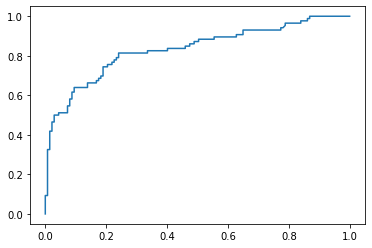

In [613]:
y_score = model.predict_proba(X_test_pca)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test,y_score)
roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr)
print(roc_auc)

In [614]:
save_obj((model,labels,means,cats),'titanic')

In [615]:
model,labels,means,cats = load_obj('titanic')

In [616]:
model = GradientBoostingClassifier(n_estimators=200,max_depth=5)

In [617]:
model.fit(X_train_pca,Y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=5,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=200,
                           n_iter_no_change=None, presort='auto',
                           random_state=None, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [618]:
pred = model.predict(X_test_pca)

In [619]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       137
           1       0.81      0.69      0.74        86

    accuracy                           0.82       223
   macro avg       0.81      0.79      0.80       223
weighted avg       0.82      0.82      0.81       223



In [620]:
np.mean(Y_test == pred)

0.8161434977578476

0.8426837548803259


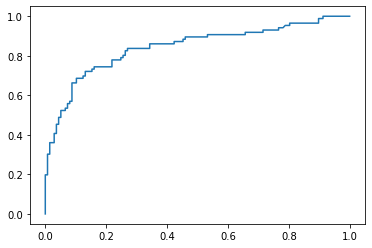

In [621]:
y_score = model.predict_proba(X_test_pca)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test,y_score)
roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr)
print(roc_auc)

In [622]:
model = RandomForestClassifier(n_estimators=200,max_depth=4)

In [623]:
model.fit(X_train_pca,Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=4, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [624]:
pred = model.predict(X_test_pca)

In [625]:
print(classification_report(Y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       137
           1       0.82      0.64      0.72        86

    accuracy                           0.81       223
   macro avg       0.81      0.78      0.79       223
weighted avg       0.81      0.81      0.80       223



In [626]:
np.mean(Y_test == pred)

0.8071748878923767

0.8329655406552368


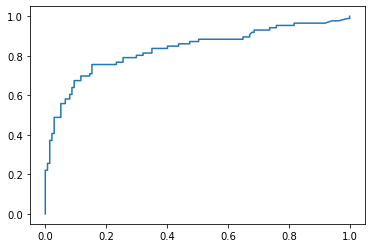

In [627]:
y_score = model.predict_proba(X_test_pca)[:,1]

fpr, tpr, thresholds = roc_curve(Y_test,y_score)
roc_auc = auc(fpr,tpr)

plt.plot(fpr,tpr)
print(roc_auc)